In [1]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn import model_selection

from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
%matplotlib inline

1. Модифицировать реализацию KNN из методички так, чтобы больший вес получали наиболее близко расположенные объекты

In [2]:
def e_metrics(x1, x2):
    return np.sqrt(np.sum((x2 - x1) ** 2))

In [3]:
def accuracy(pred, y):
    return sum(pred == y) / len(y)

In [4]:
# q - переменная для вычисления весов соседей(w(d) = q ** d)
def knn(x_train, y_train, x_test, k, q=0.5):
    answers = []
    for x in x_test:
        test_distances = []

        for i in range(len(x_train)):
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])

            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))

        # создаем словарь со всеми возможными классами, счетчиками и весами для них
        classes = {class_item: [0, 0] for class_item in set(y_train)}

        # Берем k ближайших соседей, считаем их и для каждого аккумулируем расстояния
        for d in sorted(test_distances)[0: k]:
            classes[d[1]][0] += 1
            # вес считаем по формуле w = q ^ d (q в пределах (0, 1), поэтому, чем больше 
            # расстояние, тем меньше итоговый вес)
            classes[d[1]][1] += q ** d[0]

        # Записываем в список ответов класс с наибольшим весом
        answers.append(max(classes.items(), key=lambda n: n[1][1])[0])
    return answers

In [5]:
X, y = load_iris(return_X_y=True)

X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,
                                                                    random_state=1)

k = 5
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


2. Реализовать иерархическую кластеризацию с любой из межкластерных метрик, кроме рассмотренной на вебинаре(Average Linkage Distance). Межкластерные метрики(Intercuster Distance) находятся здесь: https://www.geeksforgeeks.org/ml-intercluster-and-intracluster-distance/

In [6]:
X, y = make_blobs(n_samples=100, random_state=42)

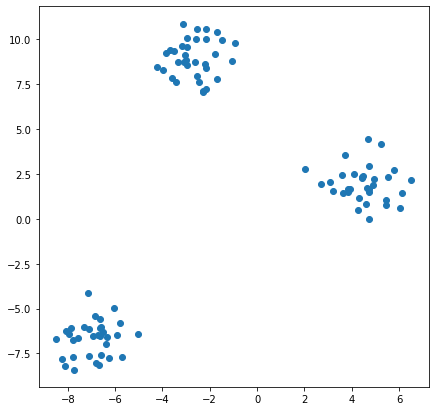

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1]);

In [8]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b', 'm']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [9]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [10]:
max_iterations = 10
min_distance = 1e-4
k = 4

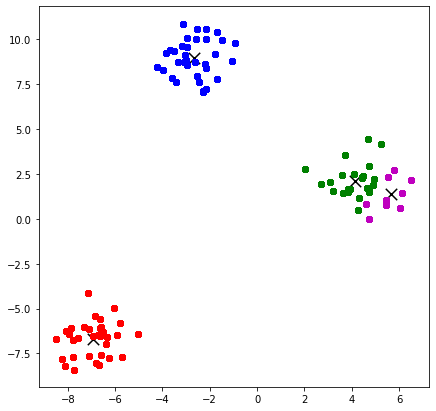

In [11]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)
visualize(centroids, clusters)

___

<b>Single Linkage Distance:</b> наименьшее расстояние между двумя объектами, принадлежащими двум кластерам  

$$ \delta_1(S, T) = \min \bigg\{d(x, y) _{ x \in S, y \in T} \bigg\} $$

In [12]:
def single_dist(u_clast, v_clast):
  return min(e_metrics(x, y) for x in u_clast for y in v_clast)

<b>Complete Linkage Distance:</b> расстояние между наиболее удаленными объектами, принадлежащими двум разным кластерам    

$$ \delta_2(S, T) = \max \bigg\{d(x, y) _{ x \in S, y \in T} \bigg\} $$

In [13]:
def complete_dist(u_clast, v_clast):
  return max(e_metrics(x, y) for x in u_clast for y in v_clast)

<b>Average Linkage Distance:</b> среднее расстояние между всеми объектами, принадлежащими двум кластерам

$$ \delta_3(S, T) = \frac{1}{|S||T|}\sum_{x \in S \\ y \in T}d(x, y) $$

In [14]:
def mean_dist(u_clast, v_clast):
  return sum((e_metrics(x, y) for x in u_clast for y in v_clast))/(len(u_clast)*len(v_clast))

<b>Centroid Linkage Distance:</b> расстояние между центрами $v_s$ и $v_t$ двух кластеров S и T соответственно

$$ \delta_4(S, T) = d(v_s, v_t) $$

где,

$$ v_s = \frac{1}{|S|}\sum_{x \in S}x $$
$$ v_t = \frac{1}{|T|}\sum_{y \in T}y $$

In [15]:
def centroid_dist(u_clast, v_clast):
  return e_metrics(np.average(u_clast, axis=0), np.average(v_clast, axis=0))

<b>Average Centroid Linkage Distance:</b> среднее расстояние между центром кластера и всеми объектами, принадлежащими другому кластеру

$$ \delta_5(S, T) = \frac{1}{|S|+|T|}\bigg\{\sum_{x \in S}d(x, vt)+\sum_{y \in T}d(y, vs)\bigg\} $$

In [16]:
def mean_centroid_dist(u_clast, v_clast):
    v1, v2 = np.average(u_clast, axis=0), np.average(v_clast, axis=0)
    sum_1 = sum(e_metrics(x, v2) for x in u_clast)
    sum_2 = sum(e_metrics(y, v1) for y in v_clast)
    return (sum_1 + sum_2) / (len(u_clast) + len(v_clast))

___

Иерархическая кластеризация с применением Average centroid linkage distance

In [17]:
def dist_matrix(clusters):
  matrix=np.zeros((len(clusters), len(clusters)))
  for i, u in enumerate(clusters):
    for j, v in enumerate(clusters[i+1:], start=i+1):
      matrix[[i, j], [j, i]]=mean_centroid_dist(u, v)
  return matrix

In [18]:
def indexes_to_combine(dist_matrix):
  min_el=dist_matrix[np.triu_indices(dist_matrix.shape[0], 1)].min()
  return np.argwhere(dist_matrix==min_el)[0], min_el

In [19]:
def exclude_clusters(i, j, dist_matrix):
  mask=np.ones(dist_matrix.shape[0], dtype=bool)
  mask[i]=False
  mask[j]=False
  return dist_matrix[mask, :][:, mask]

def merge_clusters(i, j, clusters):
  new_cluster=clusters[i]+clusters[j]
  return new_cluster, [c for k, c in enumerate(clusters) if not k in [i, j]]

def include_cluster(dist_mat, old_clusters, new_cluster):
  new_col=np.array([mean_centroid_dist(c, new_cluster) for c in old_clusters])[:, np.newaxis]
  dist_mat=np.concatenate([dist_mat, new_col], axis=1)
  new_row=np.concatenate([new_col.flatten(), [0]])[np.newaxis, :]
  dist_mat=np.concatenate([dist_mat, new_row], axis=0)
  return dist_mat

In [20]:
def hierarchy_clustering(cluster_list):
  cluster_list=cluster_list[:]
  dist_mat=dist_matrix(cluster_list)
  cluster_numbers=list(range(len(cluster_list)))
  z=[]
  new_num=len(cluster_list)
  while len(cluster_list)>1:
    [i, j], min_val=indexes_to_combine(dist_mat)
    dist_mat=exclude_clusters(i, j, dist_mat)
    new_cluster, old_clusters=merge_clusters(i, j, cluster_list)
    dist_mat=include_cluster(dist_mat, old_clusters, new_cluster)
    z.append([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
    print([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
    cluster_list=old_clusters+[new_cluster]
    cluster_numbers=[n for k, n in enumerate(cluster_numbers) if not k in [i, j]]+[new_num]
    new_num+=1
  return z

In [21]:
cluster_keys=list(clusters.keys())
cluster_data=[clusters[k] for k in cluster_keys]

In [22]:
dist_matrix(cluster_data)

array([[ 0.        , 14.17559711, 16.20814503, 14.98091632],
       [14.17559711,  0.        ,  9.67177395,  1.94567053],
       [16.20814503,  9.67177395,  0.        , 11.30709684],
       [14.98091632,  1.94567053, 11.30709684,  0.        ]])

In [23]:
Z=hierarchy_clustering(cluster_data)

[1, 3, 1.945670532154877, 330]
[2, 4, 10.061249783433611, 670]
[0, 5, 15.030242745589982, 1000]


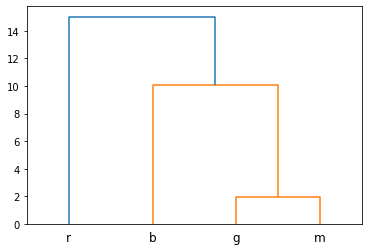

In [24]:
hierarchy.dendrogram(Z, labels= ['r', 'g', 'b', 'm']);